In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import numpy as np
from nptyping import Float32, NDArray, Number, Shape, UInt
from transformers import ViTModel
import pytorch_lightning as pl
import math
from torch.autograd import Variable

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [2]:
class SignedDataset(Dataset):
    def __init__(self, X, Y, seq_size):
        self.X = X
        self.Y = Y
        self.seq_size = seq_size

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, i):
        x_idx_a = seq_size *  i
        x_idx_z = seq_size * (i+1)
        batch_X = self.X[x_idx_a:x_idx_z]
		
        batch_Y = self.Y[i]
        return batch_X, batch_Y


In [3]:
class ViT_FeatureExtractor(pl.LightningModule):
	def __init__(
		self,
		nb_classes: int = 10,
		batch_size: int = 2,
		seq_size: int = 2,
		out_features: int = 64,
	):
		super().__init__()
		self.save_hyperparameters()

		self.batch_size = batch_size
		self.seq_size = seq_size
		self.pretrained_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
		self.pretrained_vit.eval()
		self.conv_1d_1 = torch.nn.Conv1d(
			in_channels=197,
			out_channels=self.hparams.out_features,
			kernel_size=768,
		)
		self.layer_1_relu = nn.ReLU()
		# self.conv_1d_2 = torch.nn.Conv1d(
		# 	in_channels=64,
		# 	out_channels=nb_classes, # <-- i/o 1
		# 	kernel_size=3,
		# )
		# self.layer_2_relu = nn.ReLU()

	def vit_extract_features(self, x):
		# print("---VIT EXTRACT FEATURES---")
		with torch.no_grad():
			outputs = self.pretrained_vit(pixel_values=x)
			vit_feat = outputs.last_hidden_state
			# print(f"{vit_feat.shape = }")
			# vit_feat = torch.flatten(vit_feat, start_dim=1)
			# b, f = vit_feat.size()
			# vit_feat = torch.reshape(vit_feat, (self.batch_size, self.seq_size, f))
		return vit_feat
	
	def forward(
		self,
		vit_feat, 
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		# print("---VIT FORWARD---")
		# print(f"{vit_feat.shape = }")
		x = self.conv_1d_1(vit_feat)
		# print(f"{x.shape = }")
		x = self.layer_1_relu(x)
		# print(f"{x.shape = }")
		x = torch.squeeze(x, dim=2)
		# print(f"{x.shape = }")
		return x


In [4]:
class GRU_Translator(pl.LightningModule):
	def __init__(
		self,
		nb_classes,
		H_input_size: int = 151296,
		H_output_size: int = 10,
		num_layers: int = 1,
		dropout: int = 0,
	):
		# print("---GRU INIT---")
		super().__init__()
		self.save_hyperparameters()
		self.vocabulary_size = nb_classes
		self.layer_gru = nn.GRU(
			input_size=self.hparams.H_input_size,
			hidden_size=self.hparams.nb_classes,
			num_layers=self.hparams.num_layers,
			batch_first=True,
			dropout=self.hparams.dropout
		)
		
		self.layer_1_dense = nn.Linear(self.hparams.nb_classes, self.hparams.nb_classes)
		# self.layer_1_dense = nn.Linear(self.hparams.nb_classes, int(self.hparams.nb_classes / 2))
		# self.layer_2_dense = nn.Linear(int(self.hparams.nb_classes / 2), self.hparams.nb_classes)

		self.layer_1_relu = nn.ReLU()
		# self.layer_2_dense = nn.Linear(self.hparams.H_output_size, self.vocabulary_size)
		self.layer_leaky_relu = nn.LeakyReLU()
		self.softmax = nn.Softmax(dim=2) # <-- i/o dim=2

	def forward(self, X):
		X, _ = self.layer_gru(X)
		X = self.layer_1_dense(X)
		# X = self.layer_1_relu(X)
		# X = self.layer_2_dense(X)
		X = self.softmax(X)
		return X


In [5]:
class BaseSquareNet(pl.LightningModule):
	def __init__(
		self,
		batch_size: int = 1,
		seq_size: int = 1,
		nb_classes: int = 10,
		h_in: int = 10,
		k_features: int = 64,
	):
		super().__init__()
		self.save_hyperparameters()

		self.image_feature_extractor = ViT_FeatureExtractor(
			nb_classes=self.hparams.nb_classes, 
			batch_size=self.hparams.batch_size, 
			seq_size=self.hparams.seq_size,
			out_features=self.hparams.k_features
		)
		self.recurrent_translator = GRU_Translator(
			nb_classes = nb_classes,
			H_input_size=h_in,
			num_layers=1,
			dropout=0
		)

	def forward(
		self, x: NDArray[Shape["* batch, 224, 224, 3"], Float32]
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		# print(f"IN: {x.shape=}")
		b, s, k, f = x .size()
		x = x.view(b * s, k, f)
		# print(f"VIT: {x.shape=}")

		x = self.image_feature_extractor(x)
		# print(f"FEAT: {x.shape=}")

		b = self.hparams.batch_size
		s = self.hparams.seq_size
		f = self.hparams.k_features

		x = torch.flatten(x, start_dim=1)
		bs, _f = x.size()
		# IN: x.shape=torch.Size([2, 3, 197, 768])
		# VIT: x.shape=torch.Size([6, 197, 768])
		# FEAT: x.shape=torch.Size([6, 64])
		assert(f == _f)
		assert(b * s == bs)
		x = x.view(b, s, f)
		# print(f"GRU: {x.shape=}")
		x = self.recurrent_translator(x)
		# print(f"Out: {x.shape=}")
		return x



In [6]:
b = 1
s = 3
f = 4

a = torch.arange(0, b * s * f).reshape(b * s, f)
x = a
print(f"{a = }")
print(f"{a.shape = }")

print(f"{x.shape = }")
x = torch.flatten(x, start_dim=1)
bb, ff = x.size()
x = torch.reshape(x, (bb // s, bb // b, ff))
# x = torch.unsqueeze(x, dim=0)
# x = torch.unsqueeze(x, dim=0)
print(f"{x = }")
print(f"{x.shape = }")
print(f"{x = }")
print(f"{x.shape = }")


a = tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
a.shape = torch.Size([3, 4])
x.shape = torch.Size([3, 4])
x = tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]])
x.shape = torch.Size([1, 3, 4])
x = tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]])
x.shape = torch.Size([1, 3, 4])


In [7]:
# Hyperparameters
nb_classes=10
seq_size = 3
batch_size = 2
learning_rate = 1e-4
h_in = 64


In [8]:
x = torch.rand((batch_size * seq_size, 3, 224, 224))
y = torch.randint(0, nb_classes, (batch_size, seq_size))

print(f"{x.size()=}")
print(f"{y.size()=}")
# print(f"{y=}")


x.size()=torch.Size([6, 3, 224, 224])
y.size()=torch.Size([2, 3])


In [9]:
from tqdm import tqdm 

# Models
# vit_feat = model.image_feature_extractr.vit_extract_features(x)

# dataset = SignedDataset(vit_feat, y)
model = BaseSquareNet(batch_size=batch_size, seq_size=seq_size, nb_classes=nb_classes, h_in=h_in)
vit_feat = model.image_feature_extractor.vit_extract_features(x)
dataset = SignedDataset(vit_feat, y, seq_size)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size * seq_size)
	# lr = 10 ** (- e_lr / 10)

loss_fn = torch.nn.CrossEntropyLoss()

def train(train_loader, model, loss_fn, learning_rate, epochs=100):
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	losses = []
	idx = 0
	pbar = tqdm(range(epochs))
	for epoch in pbar:
		for batch_idx, (X, y) in enumerate(train_loader):
			# print(idx)
			pred = model(X)
			# print(f"{pred.shape=}")
			pred = pred.permute(0, 2, 1)
			loss = loss_fn(pred, y)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

			# if epoch % 10 == 0:
			# 	print(f'[{epoch = }] loss: {loss}')
			idx += 1
			losses.append(float(loss.detach().numpy()))
		if epoch % 10 == 0:
			pbar.set_description(desc=f"{losses[-1]}", refresh=True)
	return losses


In [10]:
print(f"{dataset.X.shape = }")
print(f"{dataset.Y.shape = }")
print(f"{len(dataset)}")
b_x, b_y = dataset[1]
print(f"{b_x.shape = }")
print(f"{b_y.shape = }")


dataset.X.shape = torch.Size([6, 197, 768])
dataset.Y.shape = torch.Size([2, 3])
2
b_x.shape = torch.Size([3, 197, 768])
b_y.shape = torch.Size([3])


In [11]:
for batch_idx, (X, y) in enumerate(dataloader):
	print(f"{batch_idx = }")

batch_idx = 0


1.95816171169281: 100%|██████████| 1000/1000 [02:23<00:00,  6.96it/s] 


For lr = 0.0004, min(losses) = 1.9569282531738281


1.796015739440918: 100%|██████████| 1000/1000 [02:22<00:00,  7.00it/s]


For lr = 0.0005, min(losses) = 1.7930383682250977


2.11167311668396: 100%|██████████| 1000/1000 [02:23<00:00,  6.98it/s] 


For lr = 0.0006, min(losses) = 2.111318826675415


1.8647874593734741: 100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s]


For lr = 0.0007, min(losses) = 1.861989974975586


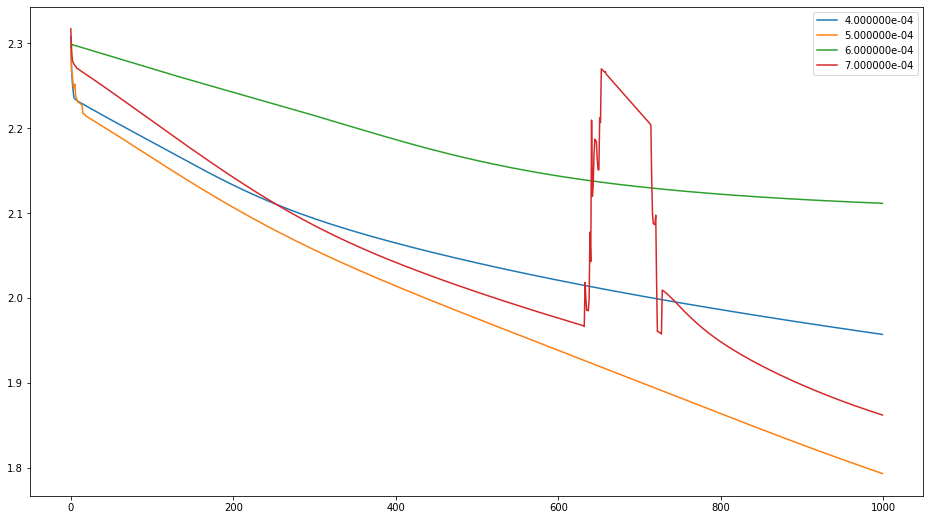

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
torch.manual_seed(6)

for lr in [4e-4, 5e-4, 6e-4, 7e-4]:
	# lr = 10 ** (- e_lr / 10)
	# model = GRU(input_size=h_in, hidden_size=5, output_size=nb_classes, num_layers=1, bias=0)
	model = BaseSquareNet(nb_classes=nb_classes, seq_size=seq_size, batch_size=batch_size, h_in=h_in)
	losses = train(dataloader, model, loss_fn, learning_rate=lr, epochs=int(1e3))
	print(f"For {lr = }, {min(losses) = }")
	plt.plot(losses, label=f"{lr:e}")
leg = plt.legend(loc='best')
plt.show()